<a href="https://colab.research.google.com/github/kimhj010502/ESAA_OB/blob/main/WEEK05_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customers clustering: K-Means, DBSCAN and AP**

https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

# Mall Customers Segmentation

## 1. Introduction


- One of the most known application of clustering are:
    - customers segmentation (for efficient marketing)
    - image segmentation
    - documents clusterisation
<br><br>
- There are many clustering algorithms which can be divided into two main types: hierarchical and partitional
    - `Hierarchical 알고리즘`: 하나의 subset이 하나의 item만 포함할 때까지 데이터셋을 더 작은 subset으로 재귀적으로 분할하며 이것은 트리처럼 보이는 dendrogram으로 나타낼 수 있음. 클러스터 개수를 지정할 필요는 없지만 splitting/merging 프로세를를 위한 종료 조건을 정의해야 함
    - `Partitional 알고리즘`: 주어진 기준에 따라 데이터셋을 여러 subset(cluster)로 나눔. K-평균과 같은 알고리즘에서는 클러스터 개수가 정의되어야 하며, DBSCAN과 같은 알고리즘에서는 정의되지 않아도 됨. 알고리즘을 실행하기 전에 클러스터 개수를 정의하려면 특정 도메인 지식이 필요한 경우가 많은데 이는 어렵고 불가능할 때도 있음. 이로 인해 도메인 지식이 없는 분석가가 적절한 수의 클러스터를 선택할 수 있도록 많은 heuristic과 단순화된 접근법이 개발되었음
<br><br>
- 여러 클러스터링 알고리즘이 있지만 최적의 것을 선택하는 것은 데이터베이스, 애플리케이션 도메인 및 고객 요구사항 및 기대치에 따라 달라짐


## 2. Reading data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('seaborn version: {}'.format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2


In [ ]:
mall_data = pd.read_csv('Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [ ]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
144,145,Male,25,77,12
139,140,Female,35,74,72
198,199,Male,32,137,18
129,130,Male,38,71,75
121,122,Female,38,67,40
30,31,Male,60,30,4
184,185,Female,41,99,39
17,18,Male,20,21,66
95,96,Male,24,60,52
92,93,Male,48,60,49


In [ ]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


- 5 columns:
    - Customer ID: numerical - unique customer number - integer
    - Gender: categorical - binary (Male/Female)
    - Age: numerical - integer
    - Annual Income (k$): numerical - integer
    - Spending Score (1-100): numerical - integer
<br><br>
- Gender이 범주형 변수이기 때문에 원-핫 인코딩을 시도할 수 있지만 사실상 권장되지는 않음

In [ ]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## 3. Exploratory Data Analysis

### 3.1 Distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


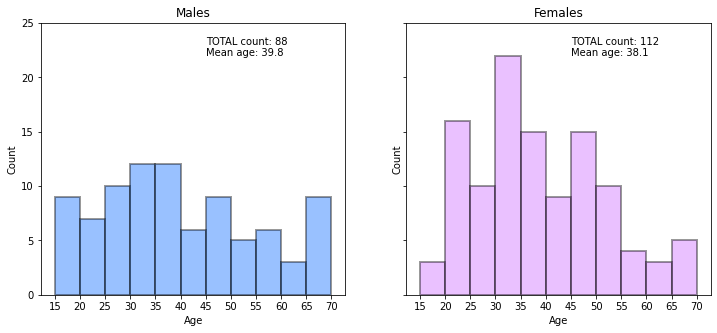

In [ ]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] #subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] #subset with females age

age_bins = range(15,75,5)

#males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, 'TOTAL count: {}'.format(males_age.count()))
ax1.text(45,22, 'Mean age: {:.1f}'.format(males_age.mean()))

#females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, 'TOTAL count: {}'.format(females_age.count()))
ax2.text(45,22, 'Mean age: {:.1f}'.format(females_age.mean()))

plt.show()

In [ ]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


- 남성 고객의 평균 연령은 여성 고객(39.8세 vs 38.1세)보다 약간 높음
- 남성 연령의 분포는 여성에 비해 균일하며, 여기서 가장 큰 연령층이 30-35세임
- Kolgomorov-Smirnov 검정은 이 두 그룹의 차이가 통계적으로 유의하지 않음을 보여줌

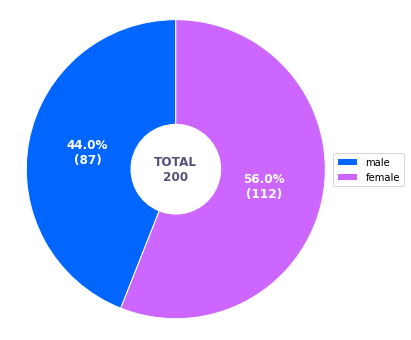

In [ ]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return '{:.1f}%\n({:d})'.format(pct, absolute)

sizes = [males_age.count(),females_age.count()] #wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  #Equal aspect ratio
plt.show()

- 여성 고객이 남성 고객(112명 vs 87명)보다 약간 더 많음
- 여성 고객은 전체 고객의 56%임

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


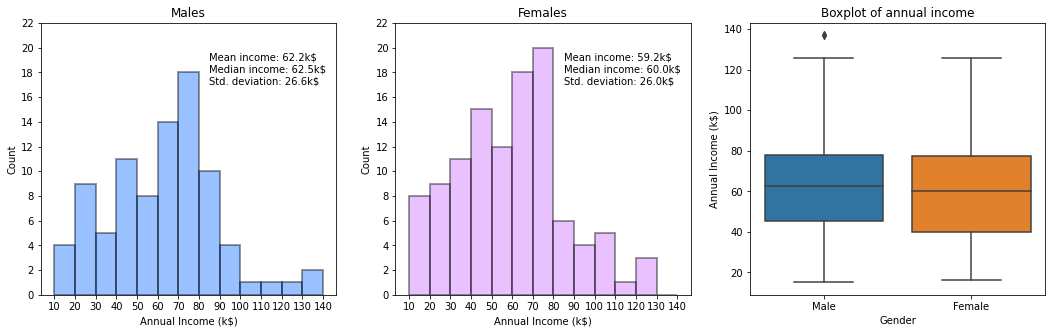

In [ ]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] #subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] #subset with females income

my_bins = range(10,150,10)

#males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, 'Mean income: {:.1f}k$'.format(males_income.mean()))
ax1.text(85,18, 'Median income: {:.1f}k$'.format(males_income.median()))
ax1.text(85,17, 'Std. deviation: {:.1f}k$'.format(males_income.std()))

#females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, 'Mean income: {:.1f}k$'.format(females_income.mean()))
ax2.text(85,18, 'Median income: {:.1f}k$'.format(females_income.median()))
ax2.text(85,17, 'Std. deviation: {:.1f}k$'.format(females_income.std()))

#boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [ ]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


- 남성의 평균 소득은 여성보다 높음 (62.2k$ vs 59.2k\$)
- 또한 남성 고객 소득의 중간값(62.5k$)이 여성 고객(60.0\$)보다 높음
- 표준 편차는 두 그룹 모두에서 유사함
- 남성 그룹에는 연간 소득이 약 140k$인 특이치가 한 명 있음
- Kolgomorov-Smirnov 검정은 이 두 그룹이 통계적으로 다르지 않다는 것을 보여줌

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


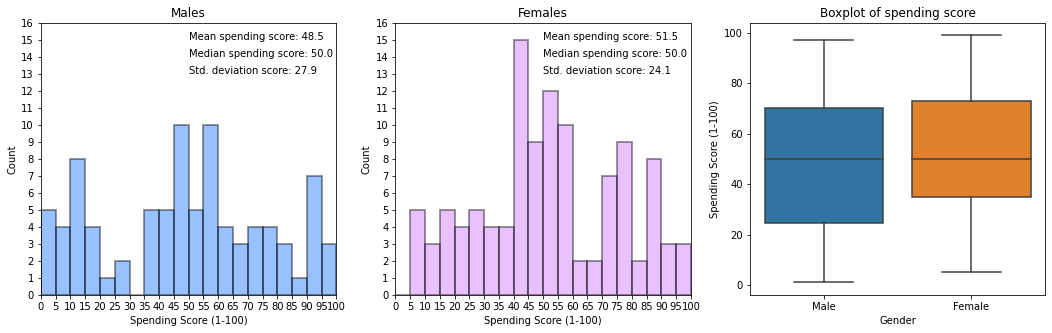

In [ ]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] #subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] #subset with females age

spending_bins = range(0,105,5)

#males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor='k', linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, 'Mean spending score: {:.1f}'.format(males_spending.mean()))
ax1.text(50,14, 'Median spending score: {:.1f}'.format(males_spending.median()))
ax1.text(50,13, 'Std. deviation score: {:.1f}'.format(males_spending.std()))

#females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor='k', linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, 'Mean spending score: {:.1f}'.format(females_spending.mean()))
ax2.text(50,14, 'Median spending score: {:.1f}'.format(females_spending.median()))
ax2.text(50,13, 'Std. deviation score: {:.1f}'.format(females_spending.std()))

#boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [ ]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


- 평균 지출 점수는 여성(51.5)이 남성(48.5)보다 높음
- Kolgomorov-Smirnov 검정 p-value는 귀무 가설을 기각할 증거가 없음을 나타내지만 이전 비교에서처럼 증거가 강력하지는 않음

In [ ]:
medians_by_age_group = mall_data.groupby(['Gender',pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

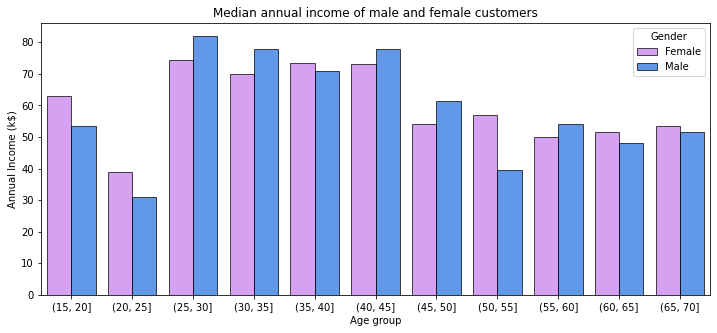

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

- 위의 bar chart는 가장 부유한 고객들이 25-45세라는 것을 보여줌
- 여성과 남성의 가장 큰 차이는 25-30세(남성이 더 부유함)와 50-55세(여성이 더 부유함)에서 볼 수 있음

### 3.2 Correlations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


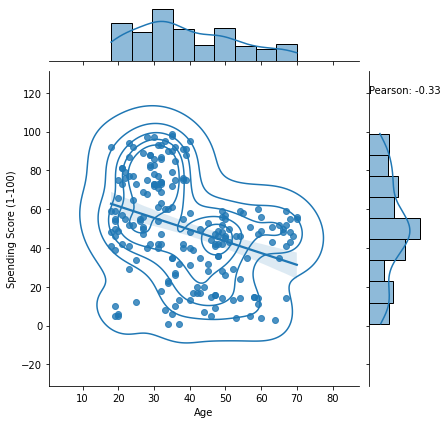

In [ ]:
from scipy.stats import pearsonr

#calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


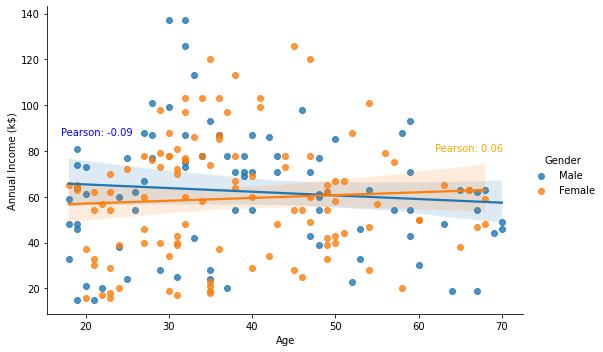

In [ ]:
#calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(17,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(62,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

두 성별 모두 Age와 Annual Income 사이에 상관관계가 거의 없음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


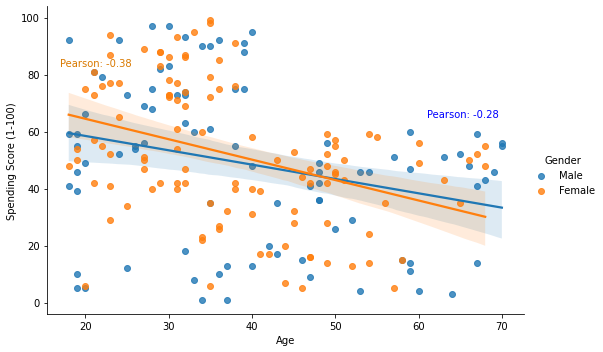

In [ ]:
#calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(61,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(17,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

두 성별 모두 Age와 Spending Score 사이에 약한 (0.5 미만의) 음의 상관관계가 있음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


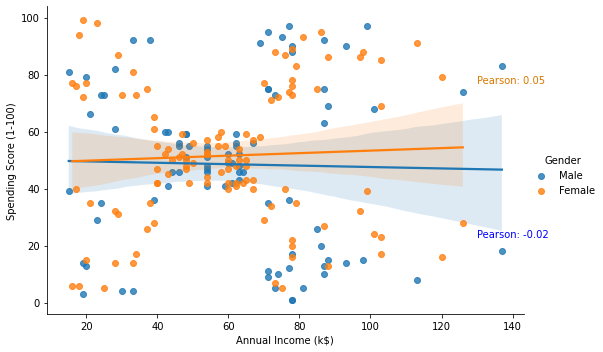

In [ ]:
#calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

두 성별 모두 Annual Income과 Spending Score 사이에 상관관계가 거의 없음

## 4. Clustering

- This section of the notebook describes and demonstrates how to use three clustering algorithms:
    - K-Means
    - Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
    - Affinity Propagation
<br><br>
- 데이터는 표준화하지 않음

### 4.1 K-Means

#### 4.1.1 Description


- There are 3 main steps in K-Means algorithm (known also as Lloyd’s algorithm):
    - Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.
    - Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.
    - The third step is to calculate newly created (updated) cluster centroids.
- Then repeat steps 2 and 3 until the algorithm converges.
<br><br>

<img src='http://drive.google.com/uc?export=view&id=1GeraQYE5RU8_2WsKVaqkAQYdLzos-lyy'><br>

This is known as NP-hard problem, meaning this is a greedy algorithm and converges to the local minimum. The computational cost of Lloyd’s K-Means algorithm is O(kn), where k is a number of clusters and n is a number of samples. This is not bad when compared with other clustering algorithms. Despite converging usually to a local minimum, K-means is relatively fast and when groups are well isolated from each other it is likely that it converges to the global minimum. Because the result of clusterisation depends on the initialisation criteria it is common to run the analysis for various initialisation points and choose the one with minimum resultant inertia. There are some improvements to the algorithm solving problem of the local minima. One, exemplary, improvement is to use enhanced Firefly Algorithms about which you can read here.
<br><br>

- In general, a user of the K-Means algorithm is required to define three main parameters:
    - **1. Initialisation criteria** <br>
    In scikit-learn, a clever initialisation scheme is implemented: “k-means++” proposed by Arthur and Vassilvitskii. It creates initial centroids generally distant from each other increasing probability of obtaining better results. There is also a possibility to use a random point’s generator. There are ongoing efforts to create the most efficient seeding method for K-Means algorithm, one of them is based on Independent Component Analysis and you can read more about it here.
    <br><br>
    - **2. Number of clusters** <br>
    Selecting a number of clusters is the most challenging part of setting this algorithm. There are no hard mathematical criteria for this and many heuristic/simplified approaches have been developed. One of the simplest and the most popular one is the elbow method shown in this analysis. Additionaly a silhouette score will be used as well. There are also other, often advanced, options for choosing the optimal number of clusters (however, not used in this notebook and not implemented in sklearn), e.g.:
        - Minimum Message Length (MML)
        - Minimum Description Length (MDL)
        - Bayes Information Criterion (BIC)
        - Akaike Information Criterion (AIC)
        - Dirichlet Process
        - Gap statistics
    <br><br>
    - **3. A distance metric (not required in scikit learn implementation)** <br>
    There are various options to calculate the distance between points. The most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn. It is often called spherical k-means model. It has a drawback that it finds spherical-like groups only and tends to become inflated in highly multi-dimensional analyses (“curse of dimensionality”). There are other options but not implemented in scikit-learn, e.g.:
        - Mahalonobis distance (high computiational cost)
        - Itakura-Saito distance
        - L1 distance
        - Cosine distance
        - Bregman distance
<br><br>
- There are numerous ongoing researches and variations proposed to K-Means, e.g.:
    - K-Medoid where the centroid is defined as the most centrally located object)
    - K-Median where the centroid is calculated using median instead of a mean,
    - Fuzzy C-means model
<br><br>
- Some take-aways about K-Means:
    - Euclidean distances are used
    - Number of clusters has to be defined for the algorithm
    - Centroid is calculated using mean distance to cluster members
    - Clusters are assumed isotropic and convex
    - Stochastic algorithm – results depend on the initialisation criteria
    - Creates groups of equal variance (minimises inertia)
    - Prone to the “curse of dimensionality”
    - Can be run in parallel – so it scales well

#### 4.1.2 Use case - customers segmentation <br>

In [ ]:
from sklearn.cluster import KMeans 

클러스터링에는 numeric column만 사용됨 (gender column은 사용되지 않음)

In [ ]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] #subset with numeric variables only

적절한 클러스터 개수를 찾기 위해 elbow를 사용함

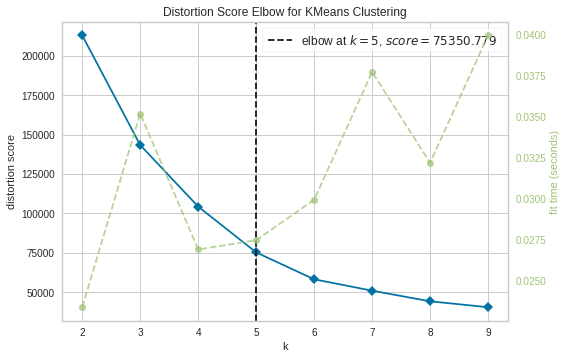

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 위의 그래프는 클러스터의 개수가 증가함에 따라 왜곡 점수가 감소함을 보여줌
- 그러나 뚜렷한 elbow가 보이지 않으나 알고리즘은 5개의 클러스터를 제안함
- 5개 또는 6개의 군집을 선택하는 것이 적절함

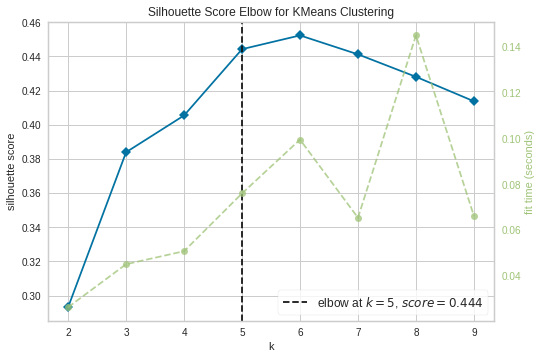

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 최적의 클러스터 개수를 선택하는 또 다른 방법은 클러스터 개수 함수로 실루엣 점수를 표시하는 것임
- 실루엣 점수 방법은 5개 또는 6개의 군집이 가장 좋은 옵션임을 나타냄




##### 5 Clusters

In [ ]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) #initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ #append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


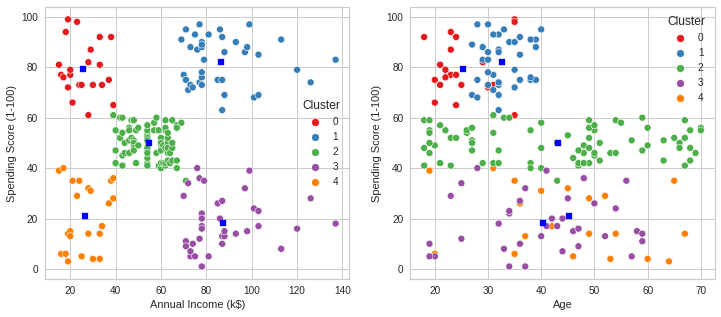

In [ ]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c='blue')
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c='blue')
plt.show()

- K-Means 알고리즘은 다음 5개의 클러스터를 생성함
    - 연간 소득이 낮고 지출 점수가 높은 고객
    - 중간 연봉과 중간 지출 점수를 가진 고객
    - 연간 소득이 높고 지출 점수가 낮은 고객
    - 연간 소득이 높고 지출 점수가 높은 고객
    - 연간 소득이 낮고 지출 점수가 낮은 고객
- 고객 연령에 따라 뚜렷한 그룹은 없음

In [ ]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ['KM_size']
KM_clust_sizes

,KM_size
Cluster,
0,22
1,39
2,79
3,37
4,23


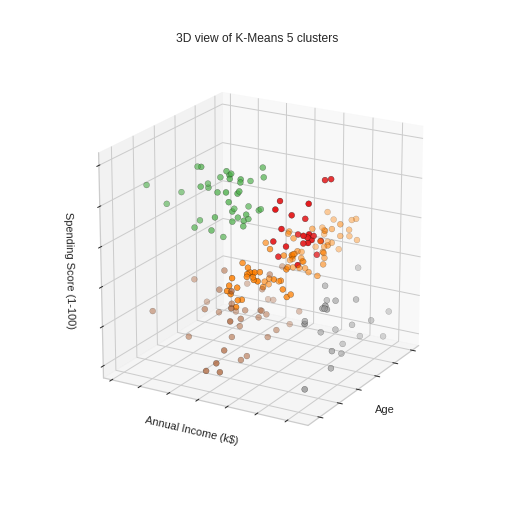

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [ ]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

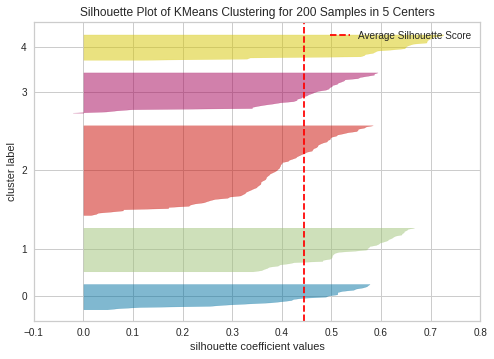

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

##### 6 Clusters

In [ ]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) #initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ #append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



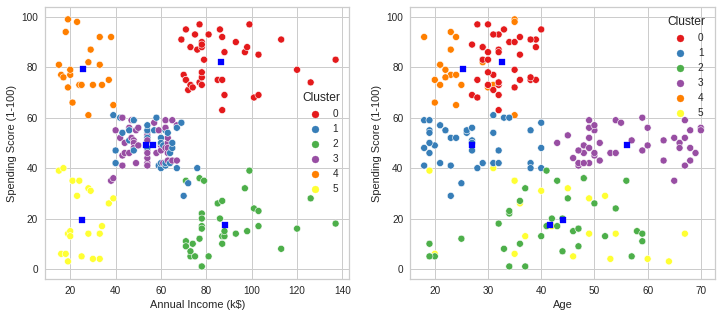

In [ ]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c='blue')
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c='blue')
plt.show()

- K-Means 알고리즘은 다음 6개의 클러스터를 생성함
    - 연간 및 중간 정도의 지출 점수를 가진 젊은 고객
    - 연간 소득이 높고 지출 점수가 낮은 고객
    - 연간 및 중간 정도의 지출 점수를 가진 젊은 고객
    - 연간 소득이 높고 지출 점수가 높은 고객
    - 연간 소득이 낮고 지출 점수가 낮은 고객
    - 연간 소득이 낮고 지출 점수가 높은 고객
- 고객 연령에 따라 뚜렷한 그룹은 없음

In [ ]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ['KM_size']
KM6_clust_sizes

,KM_size
Cluster,
0,39
1,38
2,35
3,45
4,22
5,21


In [ ]:
#Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

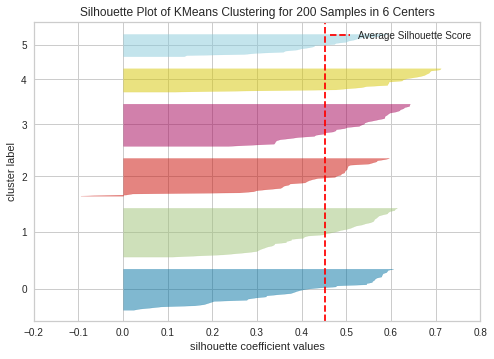

In [ ]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

### 4.2 DBSCAN

#### 4.2.1 Description

The core idea of DBSCAN is around concept of dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”.
<br><br>

- To do these two parameters are required for DBSCAN algorithm.
    - Eps, ε - distance
    - MinPts – Minimum number of points within distance Eps
- Optionally the distance metric can be specified by a user, but usually Euclidean distance is implemented (like in scikit learn).
<br><br>

A “dense region” is therefore created by a minimum number of points within distance between all of them, Eps. Points which are within this distance but not close to minimum number of other points are treated as “border points”. Remaining ones are noise or outliers. This is shown in the picture below (for MinPts=3). Red points (D) are in a “dense region” – each one has minimum of 3 neighbours within distance Eps. Green points (B) are border ones – they have a neighbour within distance Eps but less than 3. Blue point (O) is an outlier – no neighbours within distance Eps.
<br><br>
<img src='http://drive.google.com/uc?export=view&id=15GwKdXBL4STEJkfWDqIyXLxx5AF03VR7'/> 

<br>

- Advantages of this approach:
    - it finds number of clusters itself, based on eps and MinPts parameters
    - It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
    - It is also able to find points not fitting into any cluster – it detects outliers.
<br><br>
- The biggest drawback of DBSCAN:
    - High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
    - Poorly identifies clusters with various densities

#### 4.2.2 Use case - customers segmentation

In [ ]:
from sklearn.cluster import DBSCAN

- DBSCAN의 두 가지 주요 하이퍼 파라미터:
    - eps
    - min_samples

In [ ]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) #eps values to be investigated
min_samples = np.arange(3,10) #min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

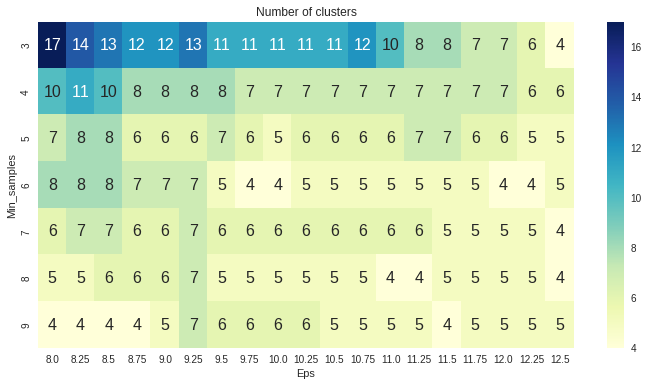

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

- 위의 히트맵은 클러스터의 수가 17개에서 4개까지 다양함을 보여줌
- 그러나 대부분의 조합은 4~7개의 클러스터를 제공함
- 어떤 조합을 사용할지 결정하기 위해 측정 기준인 실루엣 점수를 사용하고 히트맵으로 다시 표시함

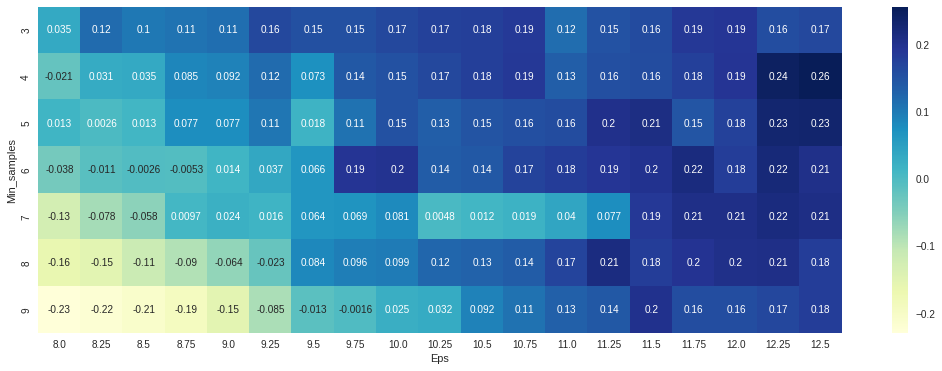

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

eps=12.5, min_samples=4일 때 최댓값 0.26 가짐

In [ ]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ #append labels to points

In [ ]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ['DBSCAN_size']
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


- DBSCAN은 5개의 클러스터와 이상치 클러스터(-1)을 만들었음
- 클러스터 0~4의 크기는 상당히 다양함
- 일부 클러스터에는 관측치가 4개 또는 8개만 있으며 이상치는 18개임

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



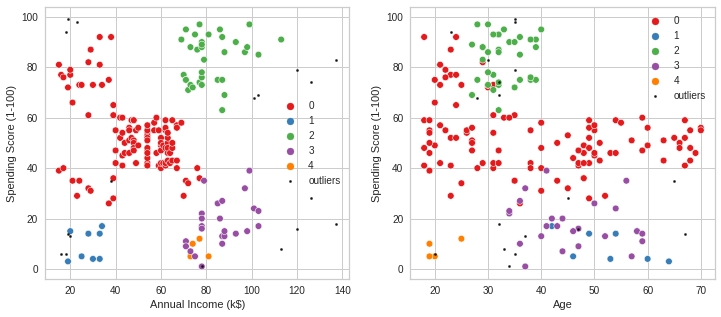

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

- 위의 그래프는 일부 이상치가 있음을 보여줌
- 이상치는 군집으로 인식되기 위한 거리 및 최소 표본 요구사항을 충족하지 않음

### 4.3 Affinity Propagation

#### 4.3.1 Description

It is built around the concept of sending messages between a pair of points until it converges. These messages are a way of measuring how similar these two points are to each other and can they be exemplars of each other. The algorithm finds an optimum number of clusters itself. This also implies very high time complexity cost of the order O(n²T) where n is the number of samples and T is the number of iterations until convergence. However, a big advantage of AP is the lack of sensitivity to the initialisation criteria.
<br><br>
- The user is required to specify two parameters:
    - Preference which is a negative number and controls how many exemplars are used
    - Damping factor which prevents numerical oscillations when updating messages
<br><br>
- Like with any other algorithms there are ongoing efforts to improve it, e.g.:
    - P.Ling and his team proposed and “Adjustable Preference Affinity Propagation (APAP)” algorithm which can produce better clustering results due to improvement to the element preference calculations
    - H. Wenlong and his team proposed “Transfer affinity propagation-based clustering” which out-performs current algorithm in a case of a very small dataset.

#### 4.3.2 Use case - customers segmentation

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
no_of_clusters = []
preferences = range(-20000,-5000,200) #arbitraty chosen range
af_sil_score = [] #silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() #display only 5 best scores

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
63,-7400.0,6.0,0.451440
26,-14800.0,6.0,0.451440
46,-10800.0,6.0,0.451440
14,-17200.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



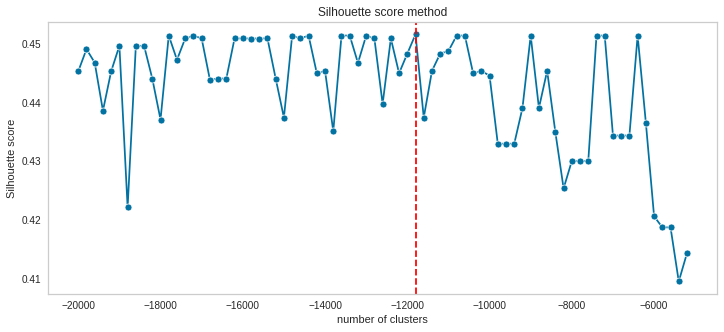

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title('Silhouette score method')
ax.set_xlabel('number of clusters')
ax.set_ylabel('Silhouette score')
ax.axvline(-11800, ls="--", c='red')
plt.grid()
plt.show()

In [ ]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [ ]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ #append labels to points

In [ ]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ['AF_size']
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



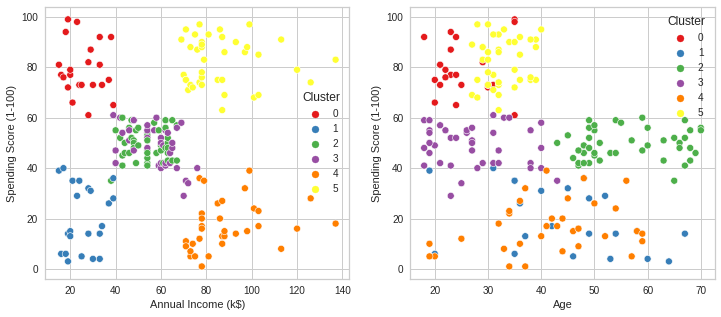

In [ ]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

Affinity Propagation 알고리즘에 의해 생성된 클러스터는 K-Means에 의해 생성된 클러스터와 유사한 비교적 고른 크기의 클러스터를 생성함

## 5. Comparison and discussion

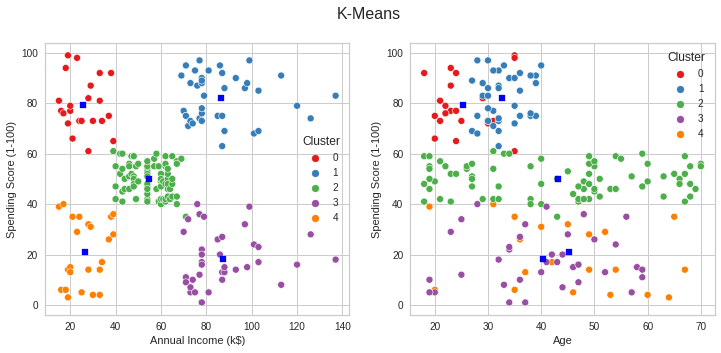

In [ ]:
fig1.suptitle('K-Means', fontsize=16)
fig1

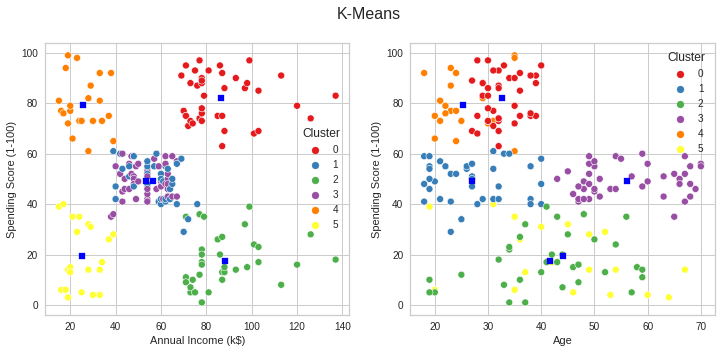

In [ ]:
fig11.suptitle('K-Means', fontsize=16)
fig11

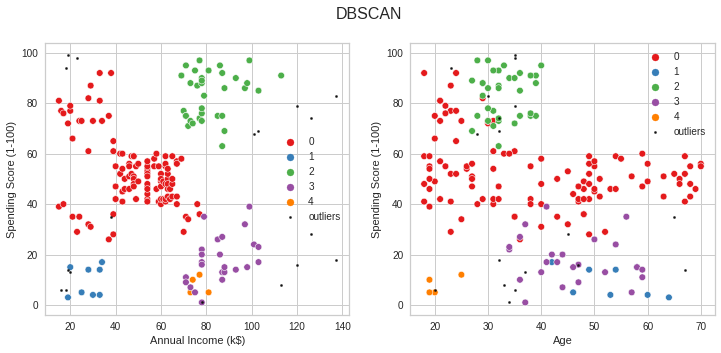

In [ ]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

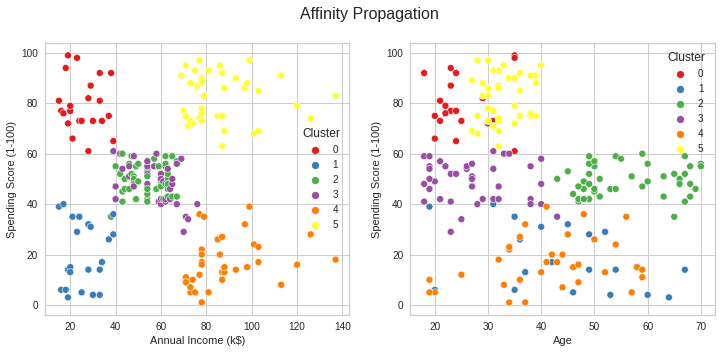

In [ ]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [ ]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,39.0,112.0,22.0
1,38.0,8.0,22.0
2,35.0,34.0,44.0
3,45.0,24.0,39.0
4,22.0,4.0,34.0
5,21.0,NaN,39.0


- K-Means의 클러스터 번호 0은 DBSCAN의 클러스터 번호 2와 같고 Affinity Propagation의 클러스터 번호 2와 같음
<br><br>
- 위의 비교를 통해 DBSCAN이 합리적인 클러스터를 생성하지 못했다는 것을 명백하게 알 수 있음
- 이는 DBCSAN이 점 밀도에 따라 클러스터를 찾으려고 하기 때문일 수 있음
- 클러스터 중 하나가 다른 클러스터보다 밀도가 낮은 경우 DBSCAN은 가장 밀도가 낮은 그룹을 클러스터로 인식하지 않음으로써 차선의 결과를 생성함
<br><br>
- 결과적으로, K-Means와 Affinity Propagation 알고리즘은 합리적인 6개의 클러스터를 만들었음